In [1]:
!pip install pandas==1.3.4

     |████████████████████████████████| 11.3 MB 7.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [128]:
!python --version

Python 3.7.12


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/oss-project/PokemonData.zip" -d "/content"

In [3]:
!rm -rf PokemonData/test/.DS_Store
!rm -rf PokemonData/train/.DS_Store
!rm -rf PokemonData/validation/.DS_Store

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
tf.__version__

'2.7.0'

In [7]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/oss-project/'

In [8]:
# data_dir = ROOT + 'PokemonData/'
data_dir = 'PokemonData/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'
validation_dir = data_dir + 'validation/'

In [9]:
train_data = os.listdir(train_dir)
test_data = os.listdir(test_dir)
validation_data = os.listdir(validation_dir)

In [10]:
# train_data.remove('.DS_Store')
# validation_data

In [11]:
n_classes = len(train_data)

In [12]:
def get_data_cnt(data, data_dir):
    cnt = 0

    for pokemon in data:
        cnt += len(os.listdir(data_dir + pokemon))

    return cnt

In [13]:
train_num = get_data_cnt(train_data, train_dir)
test_num = get_data_cnt(test_data, test_dir)
val_num = get_data_cnt(validation_data, validation_dir)
print('train 이미지 개수', train_num)
print('test 이미지 개수', test_num)
print('validation 이미지 개수', val_num)
print('포켓몬 종류', len(train_data))

train 이미지 개수 9691
test 이미지 개수 1127
validation 이미지 개수 1127
포켓몬 종류 151


In [23]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
                    train_dir,
                    target_size=(224, 224),
                    batch_size=64,
                    class_mode='categorical')
val_generator = val_gen.flow_from_directory(
                    validation_dir,
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    class_mode='categorical',
                    target_size=(224, 224))

Found 9691 images belonging to 151 classes.
Found 1127 images belonging to 151 classes.
Found 1127 images belonging to 151 classes.


In [25]:
with tf.device('/device:GPU:0'):
    resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    # model.layers[0].trainable = False
    model.summary()
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_num//64,  
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_num//32,
        workers=8
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 151)               309399    
                                                                 
Total params: 23,897,111
Trainable params: 23,843,991
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/30
151/151 [==============================] - 77s 452ms/step - loss: 2.0431 - accuracy: 0.5262 - val_loss: 11.7798 - val_accuracy: 0.0045
Epoch 2/30
151/151 [==============================] - 71s 453ms/step - loss: 0.5383 - acc

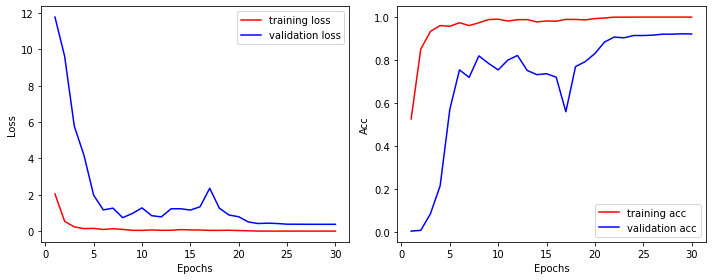

In [26]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'r', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
pred = model.predict(test_generator)


In [28]:
predicted_class_indices=np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [29]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,Abra/Abra20.jpg,Raticate
1,Abra/Abra21.jpg,Rapidash
2,Abra/Abra22.jpg,Slowpoke
3,Abra/Abra34.jpg,Persian
4,Abra/Abra35.jpg,Poliwag
...,...,...
1122,Zubat/Zubat26.jpg,Wigglytuff
1123,Zubat/Zubat27.jpg,Growlithe
1124,Zubat/Zubat31.jpg,Krabby
1125,Zubat/Zubat32.jpg,Gengar


In [32]:
from sklearn.metrics import accuracy_score

y_true = [filename.split('/')[0] for filename in filenames]

score = accuracy_score(y_true, predictions)

In [33]:
score

0.008873114463176575

In [37]:
model.save(ROOT + 'resnet_overfitting.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Data Augmentation

In [14]:
train_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
                    train_dir,
                    target_size=(224, 224),
                    batch_size=64,
                    class_mode='categorical')
val_generator = val_gen.flow_from_directory(
                    validation_dir,
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    class_mode='categorical',
                    target_size=(224, 224))

Found 9691 images belonging to 151 classes.
Found 1127 images belonging to 151 classes.
Found 1127 images belonging to 151 classes.


In [15]:
with tf.device('/device:GPU:0'):
    resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.summary()
    recall = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_num//64,  
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_num//32,
        workers=8,
        callbacks=[recall]
    )

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 151)               309399    
                                                                 
Total params: 23,897,111
Trainable params: 23,843,991
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/30
151/151 [====================

In [16]:
# tf.keras.optimizers.Adam(learning_rate=0.0005, decay=)

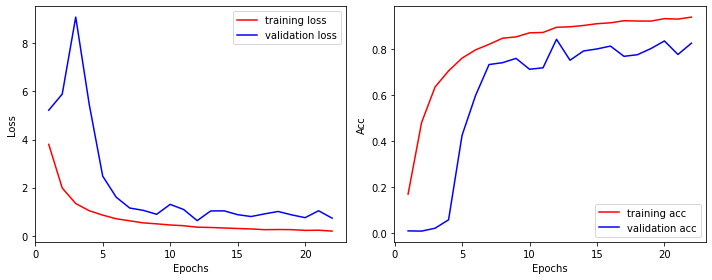

In [17]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'r', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score

pred = model.predict(val_generator)

predicted_class_indices=np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

y_true = [filename.split('/')[0] for filename in filenames]

model.save(ROOT + 'resnet_augmentation.h5')

0.009760425909494233


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [23]:
with tf.device('/device:GPU:0'):
    resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.summary()
    recall = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_num//64,  
        epochs=10,
        validation_data=val_generator,
        validation_steps=val_num//32,
        # workers=8,
        callbacks=[recall]
    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 151)               309399    
                                                                 
Total params: 23,897,111
Trainable params: 23,843,991
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10
151/151 [==============================] - 207s 1s/step - loss: 3.6249 - accuracy: 0.2032 - 

In [24]:
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


accuracy: 70.63%


In [32]:
print("-- Predict --")
output = model.predict_generator(test_generator)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output[0])

-- Predict --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, 'Farfetchd': 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hypno': 55, 'Ivysaur': 56, 'Jigglypuff': 57, 'Jolteon': 58, 'Jynx': 59, 'Kabuto': 60, 'Kabutops': 61, 'Kadabra': 62, 'Kakuna': 63, 'Kangaskhan': 64, 'Kingl

In [36]:
predicted_class_indices=np.argmax(output, axis=1)

predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,Abra/Abra20.jpg,Flareon
1,Abra/Abra21.jpg,Nidoqueen
2,Abra/Abra22.jpg,Machoke
3,Abra/Abra34.jpg,Gloom
4,Abra/Abra35.jpg,Tentacruel
...,...,...
1122,Zubat/Zubat26.jpg,Sandshrew
1123,Zubat/Zubat27.jpg,Shellder
1124,Zubat/Zubat31.jpg,Nidorino
1125,Zubat/Zubat32.jpg,Lickitung


In [105]:
raw = tf.io.read_file('/content/PokemonData/test/Abra/Abra34.jpg')

In [106]:
image = tf.image.decode_jpeg(raw, channels=3)

In [ ]:
image = tf.image.resize(image, (224, 224))
a = np.array([image])
for b in a[0]:
    print(b)
# pred = model.predict(np.array([image]).shape)

In [107]:
image = tf.cast(image, tf.float32) / 255.0
image = tf.image.resize(image, (224, 224))
# a = np.array([image])
image
pred = model.predict(np.array([image]))

In [111]:
p_c=np.argmax(pred)

In [113]:
labels[p_c]

'Moltres'

In [108]:
pred

array([[0.015, 0.000, 0.012, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.001, 0.003, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.002, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.002, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.942, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.002, 0.000, 0.001, 0.009, 0.000, 0.000, 0.000, 0.000,
        0.009, 0.000, 0.000, 0.000, 0.000, 0.002, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
      

In [118]:
m2 = tf.keras.models.load_model(ROOT + 'resnet_overfitting.h5')

In [119]:
scores = m2.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(m2.metrics_names[1], scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


accuracy: 90.62%


In [120]:
raw = tf.io.read_file('/content/PokemonData/test/Abra/Abra34.jpg')
image = tf.image.decode_jpeg(raw, channels=3)
image = tf.cast(image, tf.float32) / 255.0
image = tf.image.resize(image, (224, 224))
pred = m2.predict(np.array([image]))

In [121]:
p_c=np.argmax(pred)
labels[p_c]

'Abra'

In [122]:
with tf.device('/device:GPU:0'):
    resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.summary()
    recall = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_num//64,  
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_num//32,
        workers=8,
        callbacks=[recall]
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 151)               309399    
                                                                 
Total params: 23,897,111
Trainable params: 23,843,991
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/30
151/151 [==============================] - 184s 1s/step - loss: 3.1665 - accuracy: 0.2731 - 

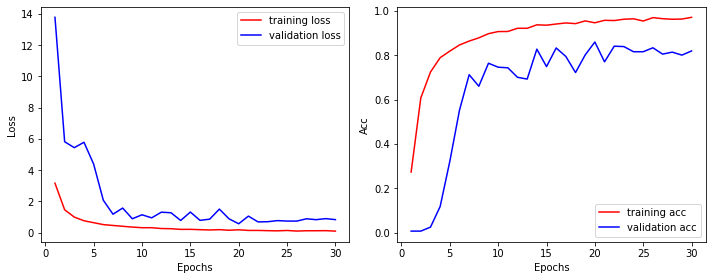

In [123]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'r', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

In [124]:
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


accuracy: 85.62%


In [125]:
print("-- Predict --")
output = model.predict_generator(test_generator)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

-- Predict --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [126]:
predicted_class_indices=np.argmax(output, axis=1)

predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,Abra/Abra20.jpg,Voltorb
1,Abra/Abra21.jpg,Dragonair
2,Abra/Abra22.jpg,Caterpie
3,Abra/Abra34.jpg,Cloyster
4,Abra/Abra35.jpg,Nidoqueen
...,...,...
1122,Zubat/Zubat26.jpg,Zubat
1123,Zubat/Zubat27.jpg,Lapras
1124,Zubat/Zubat31.jpg,Lapras
1125,Zubat/Zubat32.jpg,Articuno


In [127]:
model.save(ROOT + 'resnet_drop20.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
